In [14]:
!pip install xgboost
!pip install catboost
!pip install seaborn
!pip install optuna

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import uniform, randint
import optuna
import os
from pathlib import Path

In [16]:
# --- Загрузка данных ---
file_url_pca = 'https://drive.google.com/uc?export=download&id=1SuUhkpfj-3uJQnxwmUCyDUogfa2TixTe'
file_url_manual = 'https://drive.google.com/uc?export=download&id=1p8VYp23oOylSFrfJztQVheNLop-bX40o'

# Загрузка данных
df_pca = pd.read_csv(file_url_pca, encoding='utf-8')
df_manual = pd.read_csv(file_url_manual, encoding='utf-8')

# Вывод первых строк для проверки
print("PCA Data:")
print(df_pca.head())
print("\nManual Data:")
print(df_manual.head())

PCA Data:
   IC50, mM  CC50, mM        SI  MaxEStateIndex  MinAbsEStateIndex  \
0  1.979535  5.173221  3.371597        5.094096           0.327305   
1  0.572014  1.856738  2.079442        3.961417           0.427793   
2  5.415250  5.088474  0.542324        2.627117           0.433878   
3  0.995333  4.690023  4.162553        5.097360           0.329737   
4  4.683348  4.943576  0.832909        5.150510           0.239392   

   MinEStateIndex       qed        SPS    MolWt  HeavyAtomMolWt  ...  \
0        0.327305  0.417362  42.928571  384.652         340.300  ...   
1        0.427793  0.462473  45.214286  388.684         340.300  ...   
2        0.433878  0.260923  42.187500  446.808         388.344  ...   
3        0.329737  0.377846  41.862069  398.679         352.311  ...   
4        0.239392  0.429038  36.514286  466.713         424.377  ...   

   fr_tetrazole  fr_thiazole  fr_thiophene  fr_unbrch_alkane  fr_urea  \
0             0            0             0          1.386294   

In [22]:
# Целевые переменные
TARGETS = ['CC50, mM']

In [24]:
# --- Вспомогательная функция для расчета метрик ---
def calculate_metrics(y_true, y_pred):
    """Вычисляет RMSE, MAE и R2."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

# --- Функции для каждого метода оптимизации ---

def run_randomized_search(model_instance, param_distributions, X_train_scaled, y_train, n_iter_search=20):
    """Выполняет RandomizedSearchCV для подбора гиперпараметров."""
    if not param_distributions: # Для моделей без параметров, например, LinearRegression
        model_instance.fit(X_train_scaled, y_train)
        return model_instance, {}
    random_search = RandomizedSearchCV(model_instance, param_distributions, n_iter=n_iter_search,
                                       cv=5, scoring='neg_root_mean_squared_error',
                                       n_jobs=-1, verbose=0, random_state=42)
    random_search.fit(X_train_scaled, y_train)
    return random_search.best_estimator_, random_search.best_params_

def run_grid_search(model_instance, param_grid, X_train_scaled, y_train):
    """Выполняет GridSearchCV для подбора гиперпараметров."""
    if not param_grid: # Для моделей без параметров
        model_instance.fit(X_train_scaled, y_train)
        return model_instance, {}
    grid_search = GridSearchCV(model_instance, param_grid, cv=3, scoring='neg_root_mean_squared_error',
                               n_jobs=-1, verbose=0)
    grid_search.fit(X_train_scaled, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

def run_optuna_search(model_class, optuna_search_space, X_train_scaled, y_train, n_trials=20):
    """Выполняет оптимизацию гиперпараметров с помощью Optuna."""
    def objective(trial):
        params = optuna_search_space(trial) # Получаем параметры из триала Optuna
        model = model_class(**params) # Убираем random_state здесь, если он уже в params

        from sklearn.model_selection import KFold
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        for train_idx, val_idx in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            if isinstance(model, CatBoostRegressor):
                # CatBoost может иметь проблемы с именами столбцов/индексами, если они не простые
                # Создаем Pool для CatBoost, если данные являются Pandas Series/DataFrame
                try:
                    from catboost import Pool
                    train_pool = Pool(X_train_fold, y_train_fold)
                    val_pool = Pool(X_val_fold, y_val_fold)
                    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=10, verbose=False)
                except Exception as e:
                    print(f"Ошибка при обучении CatBoost в Optuna: {e}")
                    # Возвращаем очень большое значение, чтобы Optuna избегала этих параметров
                    return float('inf')
            else:
                model.fit(X_train_fold, y_train_fold)

            y_val_pred = model.predict(X_val_fold)
            rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
            cv_scores.append(rmse_fold)
        return np.mean(cv_scores)

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    # show_progress_bar=False, чтобы не засорять вывод в Colab
    # Добавляем (Exception,) в catch для более общего перехвата ошибок внутри objective
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False, catch=(ValueError, Exception))

    best_params = study.best_params
    best_model_instance = model_class(**best_params) # Убираем random_state здесь, если он уже в params

    if isinstance(best_model_instance, CatBoostRegressor):
        try:
            from catboost import Pool
            train_pool_final = Pool(X_train_scaled, y_train)
            best_model_instance.fit(train_pool_final, verbose=False)
        except Exception as e:
            print(f"Ошибка при окончательном обучении CatBoost: {e}")
            return None, {} # Возвращаем None, если окончательное обучение не удалось
    else:
        best_model_instance.fit(X_train_scaled, y_train)

    return best_model_instance, best_params


# --- Общая функция для оценки моделей с различными оптимизаторами ---
def evaluate_model_with_optimizer(model_name, model_class, params_config, X, y, target_name, optimizer_type):
    """Оценивает производительность модели, используя указанный метод оптимизации."""

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    best_model = None
    best_params = {}

    if optimizer_type == 'RandomizedSearchCV':
        param_distributions = params_config.get('random_dist', {})
        # Для LinearRegression, Ridge, Lasso, у которых random_dist может быть пустым
        # если нет настраиваемых параметров, или мы хотим использовать более простую модель
        if model_name in ["LinearRegression"] and not param_distributions:
            model_instance = model_class()
            model_instance.fit(X_train_scaled, y_train)
            best_model, best_params = model_instance, {}
        else:
            best_model, best_params = run_randomized_search(model_class(), param_distributions, X_train_scaled, y_train, n_iter_search=20)

    elif optimizer_type == 'GridSearchCV':
        param_grid = params_config.get('grid_params', {})
        if not param_grid:
            # Для моделей без сетки, просто обучаем без подбора
            model_instance = model_class()
            model_instance.fit(X_train_scaled, y_train)
            best_model, best_params = model_instance, {}
        else:
            best_model, best_params = run_grid_search(model_class(), param_grid, X_train_scaled, y_train)

    elif optimizer_type == 'Optuna':
        optuna_space = params_config.get('optuna_space')
        if optuna_space is None:
            # Для моделей без пространства Optuna, просто обучаем без подбора
            model_instance = model_class()
            model_instance.fit(X_train_scaled, y_train)
            best_model, best_params = model_instance, {}
        else:
            best_model, best_params = run_optuna_search(model_class, optuna_space, X_train_scaled, y_train, n_trials=20)

    else:
        raise ValueError(f"Неизвестный тип оптимизатора: {optimizer_type}")

    if best_model is None: # Если обучение CatBoost в Optuna завершилось ошибкой
        return None

    y_pred = best_model.predict(X_test_scaled)
    rmse, mae, r2 = calculate_metrics(y_test, y_pred)

    return {
        'model': model_name,
        'optimizer': optimizer_type,
        'target': target_name,
        'best_params': best_params,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }


# --- Определение моделей и их гиперпараметров для разных оптимизаторов ---
# Обновляем `suggest_loguniform` на `suggest_float(..., log=True)`
# Увеличиваем `max_iter` для MLPRegressor

models_config = {
    "LinearRegression": {
        "class": LinearRegression,
        "random_dist": {},
        "grid_params": {}, # Нет настраиваемых параметров для базовой LinearRegression
        "optuna_space": None
    },
    "Ridge": {
        "class": Ridge,
        "random_dist": {'alpha': uniform(loc=0.1, scale=20)},
        "grid_params": {'alpha': [0.1, 1.0, 10.0]}, # Ограниченная сетка для GridSearchCV
        "optuna_space": lambda trial: {'alpha': trial.suggest_float('alpha', 0.1, 20, log=True)}
    },
    "Lasso": {
        "class": Lasso,
        "random_dist": {'alpha': uniform(loc=0.001, scale=1.0)},
        "grid_params": {'alpha': [0.001, 0.01, 0.1]}, # Ограниченная сетка для GridSearchCV
        "optuna_space": lambda trial: {'alpha': trial.suggest_float('alpha', 0.001, 1.0, log=True), 'max_iter': 2000}
    },
    "RandomForestRegressor": {
        "class": RandomForestRegressor,
        "random_dist": {
            'n_estimators': randint(50, 200),
            'max_depth': [5, 10, None],
            'min_samples_split': randint(2, 8)
        },
        "grid_params": { # Очень ограниченная сетка для GridSearchCV
            'n_estimators': [100, 150],
            'max_depth': [5, 10],
        },
        "optuna_space": lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_categorical('max_depth', [5, 10, 15, None]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
            'random_state': 42 # Добавляем random_state для воспроизводимости
        }
    },
    "XGBRegressor": {
        "class": XGBRegressor,
        "random_dist": {
            'n_estimators': randint(50, 200),
            'learning_rate': uniform(0.01, 0.15),
            'max_depth': randint(3, 8),
            'subsample': uniform(0.7, 0.3)
        },
        "grid_params": { # Ограниченная сетка для GridSearchCV
            'n_estimators': [100, 150],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        },
        "optuna_space": lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0), # uniform
            'eval_metric': 'rmse',
            'n_jobs': -1,
            'random_state': 42 # Добавляем random_state
        }
    },
    "CatBoostRegressor": {
        "class": CatBoostRegressor,
        "random_dist": {
            'iterations': randint(50, 200),
            'learning_rate': uniform(0.01, 0.15),
            'depth': randint(3, 8),
            'l2_leaf_reg': uniform(1, 7)
        },
        "grid_params": { # Ограниченная сетка для GridSearchCV
            'iterations': [100, 150],
            'learning_rate': [0.05, 0.1],
            'depth': [3, 5]
        },
        "optuna_space": lambda trial: {
            'iterations': trial.suggest_int('iterations', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            'depth': trial.suggest_int('depth', 3, 8),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),
            'verbose': False,
            'random_seed': 42,
            'thread_count': -1
        }
    },
    "MLPRegressor": {
        "class": MLPRegressor,
        "random_dist": {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'alpha': uniform(0.0001, 0.005),
            'learning_rate_init': uniform(0.0001, 0.005)
        },
        "grid_params": {
            'hidden_layer_sizes': [(50,), (100,)],
            'alpha': [0.0001, 0.001]
        },
        "optuna_space": lambda trial: {
            'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50)]),
            'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
            'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
            'max_iter': 2000, # Увеличиваем max_iter
            'random_state': 42, # Добавляем random_state
            'solver': 'adam' # Часто 'adam' сходится лучше
        }
    }
}

In [26]:
# --- Основной цикл оценки с тремя методами оптимизации ---
all_results = []
optimizers = ['RandomizedSearchCV', 'GridSearchCV', 'Optuna']

X_pca = df_pca.drop(columns=TARGETS)
X_manual = df_manual.drop(columns=TARGETS)

print("Начинаем процесс обучения и оценки моделей с различными методами оптимизации (50 итераций)...")

# Внешний прогресс-бар для целевых переменных
for target in tqdm(TARGETS, desc="Прогнозирование целевых переменных"):
    for data_source_name, X_data, df_data in [("PCA Aggregated", X_pca, df_pca), ("Manual Aggregated", X_manual, df_manual)]:
        # Внутренний прогресс-бар для оптимизаторов и моделей
        num_models_to_run = 0
        for model_name, config in models_config.items():
            for optimizer_type in optimizers:
                # Упрощенная логика для подсчета моделей
                if optimizer_type == 'RandomizedSearchCV' and not config['random_dist'] and model_name not in ["LinearRegression"]:
                     continue # Пропускаем, если random_dist пуст и это не LinearRegression
                if optimizer_type == 'GridSearchCV' and not config['grid_params'] and model_name not in ["LinearRegression"]:
                     continue # Пропускаем, если grid_params пуст и это не LinearRegression
                if optimizer_type == 'Optuna' and config['optuna_space'] is None and model_name not in ["LinearRegression"]:
                     continue # Пропускаем, если optuna_space None и это не LinearRegression
                num_models_to_run += 1

        with tqdm(total=num_models_to_run, desc=f"Оптимизация для {target} ({data_source_name})", leave=False) as pbar_inner:
            for optimizer_type in optimizers:
                for model_name, config in models_config.items():
                    # Пропускаем неподходящие комбинации модель-оптимизатор, чтобы избежать ошибок и не тратить время
                    if optimizer_type == 'RandomizedSearchCV' and not config['random_dist'] and model_name != "LinearRegression":
                        pbar_inner.update(1)
                        continue
                    if optimizer_type == 'GridSearchCV' and not config['grid_params'] and model_name != "LinearRegression":
                        pbar_inner.update(1)
                        continue
                    if optimizer_type == 'Optuna' and config['optuna_space'] is None and model_name != "LinearRegression":
                        pbar_inner.update(1)
                        continue

                    model_class = config["class"]
                    params_config = config

                    # Обновляем описание для внутреннего прогресс-бара
                    pbar_inner.set_description(f"Оптимизация для {target} ({data_source_name}) - {model_name} ({optimizer_type})")

                    result = evaluate_model_with_optimizer(model_name, model_class, params_config,
                                                           X_data, df_data[target], target, optimizer_type)
                    if result:
                        result['data_source'] = data_source_name
                        all_results.append(result)
                    pbar_inner.update(1) # Обновляем после каждого запуска модели

Начинаем процесс обучения и оценки моделей с различными методами оптимизации (50 итераций)...


Прогнозирование целевых переменных:   0%|          | 0/1 [00:00<?, ?it/s]

Оптимизация для CC50, mM (PCA Aggregated):   0%|          | 0/21 [00:00<?, ?it/s]

0:	learn: 1.5107402	total: 146ms	remaining: 26.7s
1:	learn: 1.4455487	total: 149ms	remaining: 13.5s
2:	learn: 1.3680903	total: 151ms	remaining: 9.07s
3:	learn: 1.3003720	total: 153ms	remaining: 6.86s
4:	learn: 1.2485596	total: 156ms	remaining: 5.54s
5:	learn: 1.1964070	total: 158ms	remaining: 4.66s
6:	learn: 1.1397866	total: 161ms	remaining: 4.06s
7:	learn: 1.0958838	total: 164ms	remaining: 3.59s
8:	learn: 1.0564768	total: 166ms	remaining: 3.22s
9:	learn: 1.0218094	total: 169ms	remaining: 2.92s
10:	learn: 1.0031951	total: 171ms	remaining: 2.68s
11:	learn: 0.9689332	total: 174ms	remaining: 2.48s
12:	learn: 0.9282188	total: 177ms	remaining: 2.31s
13:	learn: 0.9013364	total: 179ms	remaining: 2.16s
14:	learn: 0.8753342	total: 181ms	remaining: 2.03s
15:	learn: 0.8540691	total: 184ms	remaining: 1.92s
16:	learn: 0.8159668	total: 186ms	remaining: 1.82s
17:	learn: 0.7881381	total: 191ms	remaining: 1.75s
18:	learn: 0.7561689	total: 193ms	remaining: 1.67s
19:	learn: 0.7360654	total: 196ms	remaini

C:\Users\user\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-06-18 16:28:01,512] A new study created in memory with name: no-name-14c7f326-f1ac-4988-8ac4-e902b3d73679
[I 2025-06-18 16:28:01,544] Trial 0 finished with value: 0.48816151305504124 and parameters: {'alpha': 0.7274917088027808}. Best is trial 0 with value: 0.48816151305504124.
[I 2025-06-18 16:28:01,578] Trial 1 finished with value: 0.4881732331389973 and parameters: {'alpha': 15.40359659501924}. Best is trial 0 with value: 0.48816151305504124.
[I 2025-06-18 16:28:01,611] Trial 2 finished with value: 0.4792845086074444 and parameters: {'alpha': 4.83437145318464}. Best is trial 2 with value: 0.4792845086074444.
[I 2025-06-18 16:28:01,642] Trial 3 finished with value: 0.4820565333162493 and parameters: {'alpha': 2.385234757844707}. Best is trial 2 with

Оптимизация для CC50, mM (Manual Aggregated):   0%|          | 0/21 [00:00<?, ?it/s]

0:	learn: 1.5352068	total: 3.73ms	remaining: 680ms
1:	learn: 1.4762983	total: 7.37ms	remaining: 667ms
2:	learn: 1.3962674	total: 10.8ms	remaining: 648ms
3:	learn: 1.3565428	total: 13.3ms	remaining: 595ms
4:	learn: 1.2978235	total: 15.6ms	remaining: 557ms
5:	learn: 1.2242970	total: 18.3ms	remaining: 541ms
6:	learn: 1.1793624	total: 20.8ms	remaining: 522ms
7:	learn: 1.1516254	total: 23.3ms	remaining: 509ms
8:	learn: 1.1189929	total: 26ms	remaining: 503ms
9:	learn: 1.0900331	total: 28.5ms	remaining: 492ms
10:	learn: 1.0487982	total: 31ms	remaining: 485ms
11:	learn: 0.9970465	total: 33.7ms	remaining: 480ms
12:	learn: 0.9665158	total: 35.9ms	remaining: 470ms
13:	learn: 0.9347875	total: 38.5ms	remaining: 465ms
14:	learn: 0.9031712	total: 42ms	remaining: 471ms
15:	learn: 0.8592660	total: 44.4ms	remaining: 463ms
16:	learn: 0.8319450	total: 47.1ms	remaining: 460ms
17:	learn: 0.8162173	total: 49.7ms	remaining: 455ms
18:	learn: 0.7892164	total: 52.2ms	remaining: 450ms
19:	learn: 0.7643803	total: 

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.621e-01, tolerance: 2.059e-01
  model = cd_fast.enet_coordinate_descent(


0:	learn: 1.5347781	total: 2.93ms	remaining: 437ms
1:	learn: 1.4675816	total: 5.05ms	remaining: 374ms
2:	learn: 1.4128419	total: 6.72ms	remaining: 329ms
3:	learn: 1.3341209	total: 8.24ms	remaining: 301ms
4:	learn: 1.2764085	total: 10.2ms	remaining: 296ms
5:	learn: 1.2221626	total: 12ms	remaining: 288ms
6:	learn: 1.1825936	total: 14.1ms	remaining: 288ms
7:	learn: 1.1435313	total: 15.7ms	remaining: 278ms
8:	learn: 1.0922931	total: 17.2ms	remaining: 269ms
9:	learn: 1.0645161	total: 19ms	remaining: 266ms
10:	learn: 1.0375636	total: 20.9ms	remaining: 264ms
11:	learn: 1.0008040	total: 22.6ms	remaining: 260ms
12:	learn: 0.9642533	total: 24.2ms	remaining: 255ms
13:	learn: 0.9351668	total: 26.3ms	remaining: 256ms
14:	learn: 0.9004163	total: 28.1ms	remaining: 253ms
15:	learn: 0.8753514	total: 29.7ms	remaining: 248ms
16:	learn: 0.8453108	total: 31.3ms	remaining: 245ms
17:	learn: 0.8241701	total: 33ms	remaining: 242ms
18:	learn: 0.7956148	total: 34.6ms	remaining: 238ms
19:	learn: 0.7804319	total: 

C:\Users\user\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-06-18 16:42:13,394] A new study created in memory with name: no-name-a09a5dcd-330c-47d9-be9a-21a46516e7db
[I 2025-06-18 16:42:14,654] Trial 0 finished with value: 0.4906288679693909 and parameters: {'alpha': 0.7274917088027808}. Best is trial 0 with value: 0.4906288679693909.
[I 2025-06-18 16:42:16,248] Trial 1 finished with value: 0.4888798029619821 and parameters: {'alpha': 15.40359659501924}. Best is trial 1 with value: 0.4888798029619821.
[I 2025-06-18 16:42:18,124] Trial 2 finished with value: 0.48063909574456104 and parameters: {'alpha': 4.83437145318464}. Best is trial 2 with value: 0.48063909574456104.
[I 2025-06-18 16:42:19,562] Trial 3 finished with value: 0.48391692226491967 and parameters: {'alpha': 2.385234757844707}. Best is trial 2 with


Результаты сохранены в: model_results_all_optimizers_50_iter.csv

--- Сводка результатов по методам оптимизации ---

## Результаты RandomizedSearchCV:
                    model           optimizer    target                                                                                                    best_params      rmse       mae        r2        data_source
26      CatBoostRegressor  RandomizedSearchCV  CC50, mM        {'depth': 4, 'iterations': 183, 'l2_leaf_reg': 2.455591640077322, 'learning_rate': 0.09515504917299872}  0.237056  0.147204  0.975291  Manual Aggregated
5       CatBoostRegressor  RandomizedSearchCV  CC50, mM        {'depth': 4, 'iterations': 183, 'l2_leaf_reg': 2.455591640077322, 'learning_rate': 0.09515504917299872}  0.237256  0.139811  0.975249     PCA Aggregated
4            XGBRegressor  RandomizedSearchCV  CC50, mM   {'learning_rate': 0.07757488779543144, 'max_depth': 4, 'n_estimators': 181, 'subsample': 0.9826605267054558}  0.307171  0.135557  0.958513    

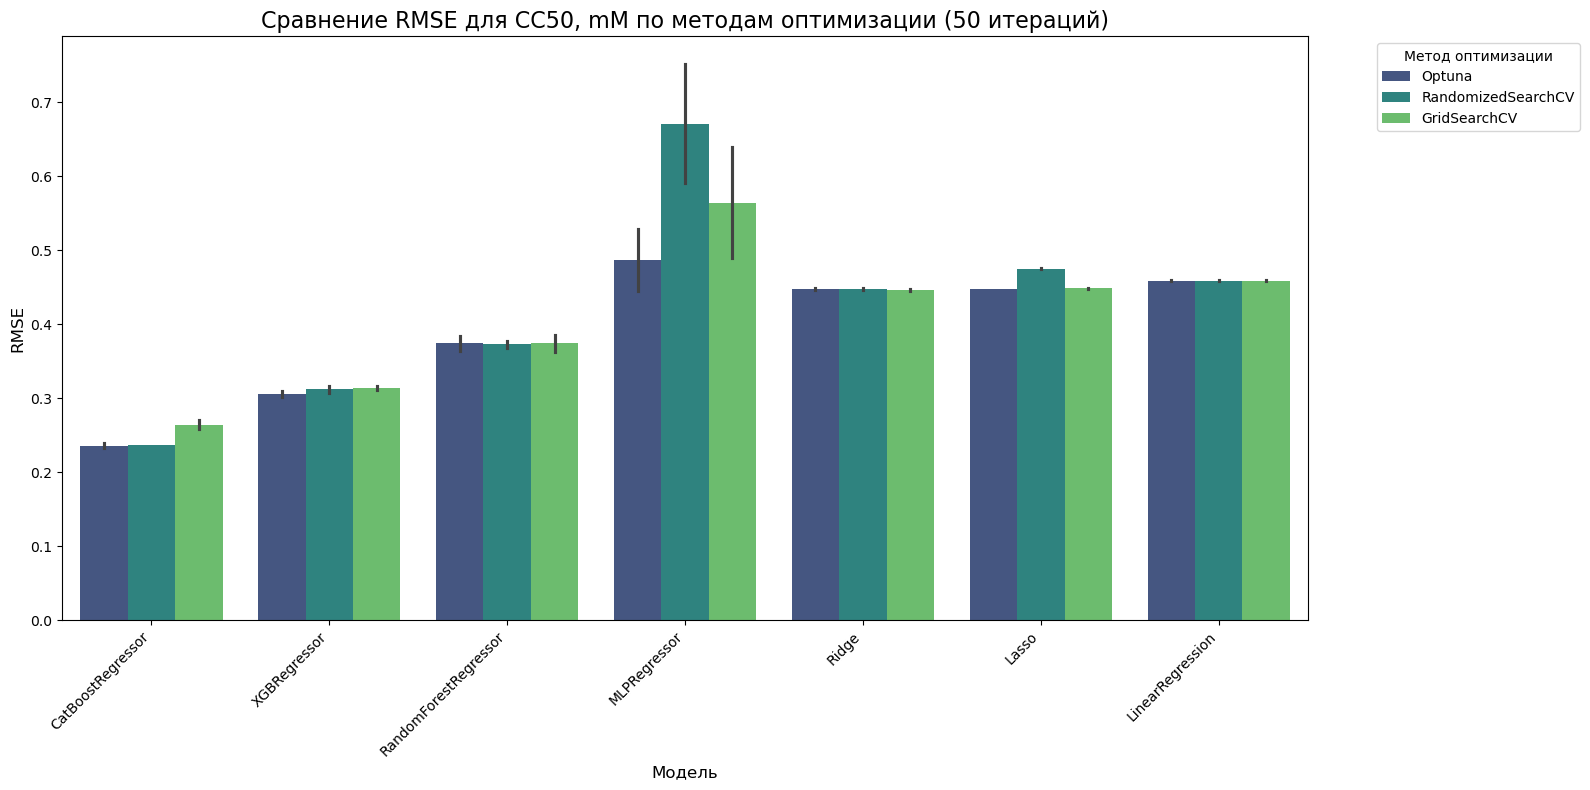

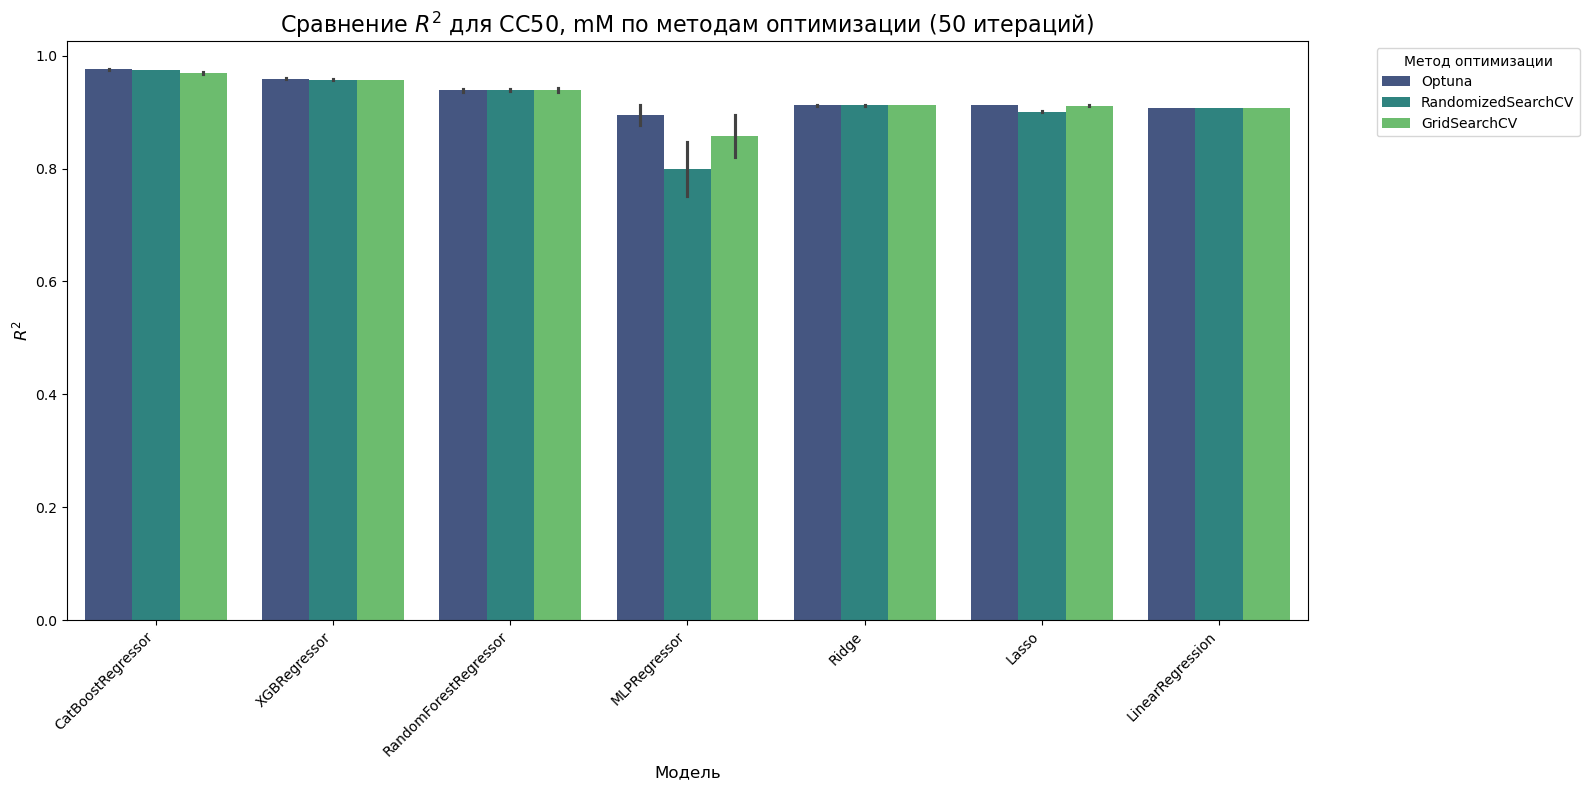

In [27]:
# --- Сохранение и вывод результатов ---
output_file = Path('model_results_all_optimizers_50_iter.csv')

all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv(output_file, index=False)
print(f"\nРезультаты сохранены в: {output_file}")

print("\n--- Сводка результатов по методам оптимизации ---")

# Группируем результаты по оптимизатору, затем по целевой переменной и модели
for optimizer in optimizers:
    print(f"\n## Результаты {optimizer}:")
    subset_optimizer = all_results_df[all_results_df['optimizer'] == optimizer]
    # Сортируем внутри каждой группы оптимизатора
    print(subset_optimizer.sort_values(by=['target', 'rmse']).to_string())
    print("\n" + "-"*50 + "\n") # Разделитель

# Визуализация
for target in TARGETS:
    plt.figure(figsize=(16, 8))
    subset = all_results_df[all_results_df['target'] == target].sort_values(by='rmse')
    sns.barplot(x='model', y='rmse', hue='optimizer', data=subset, palette='viridis')
    plt.title(f'Сравнение RMSE для {target} по методам оптимизации (50 итераций)', fontsize=16)
    plt.ylabel('RMSE', fontsize=12)
    plt.xlabel('Модель', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Метод оптимизации', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 8))
    sns.barplot(x='model', y='r2', hue='optimizer', data=subset, palette='viridis')
    plt.title(f'Сравнение $R^2$ для {target} по методам оптимизации (50 итераций)', fontsize=16)
    plt.ylabel('$R^2$', fontsize=12)
    plt.xlabel('Модель', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Метод оптимизации', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Строим графики по лучшим параметрам моделей...

Графики параметров для CatBoostRegressor:


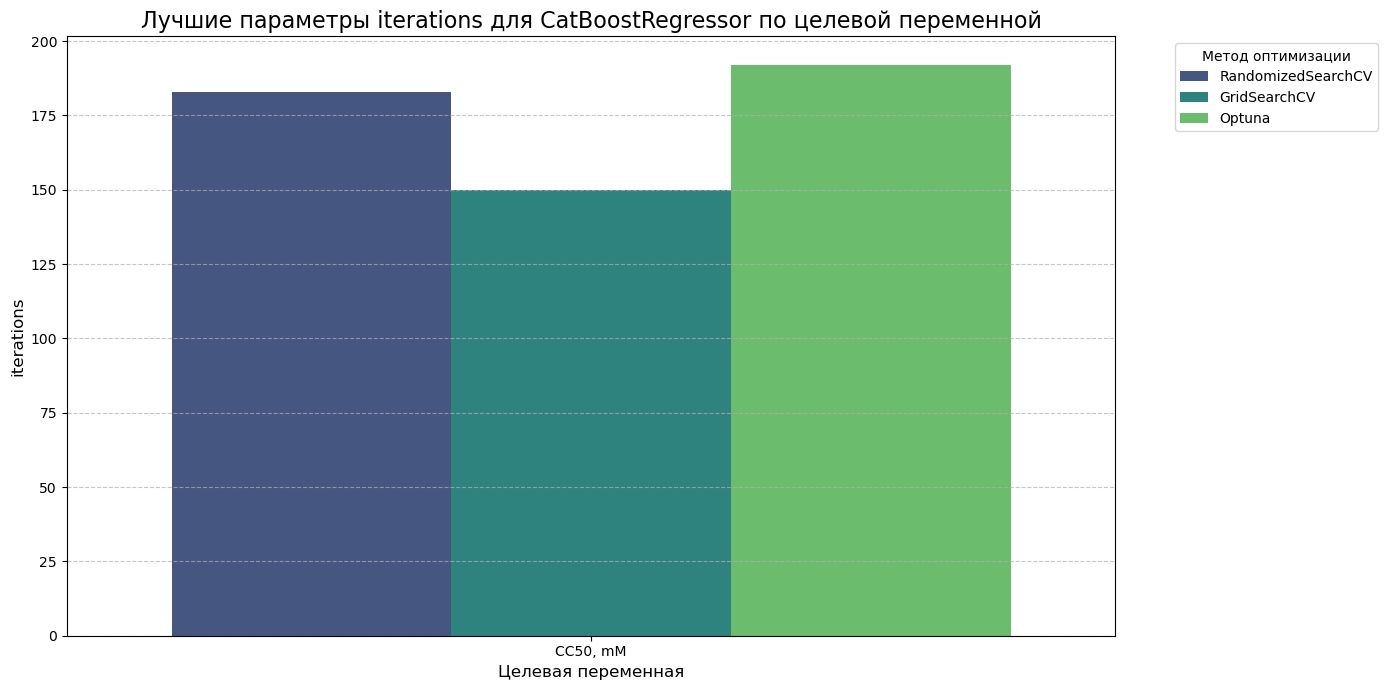

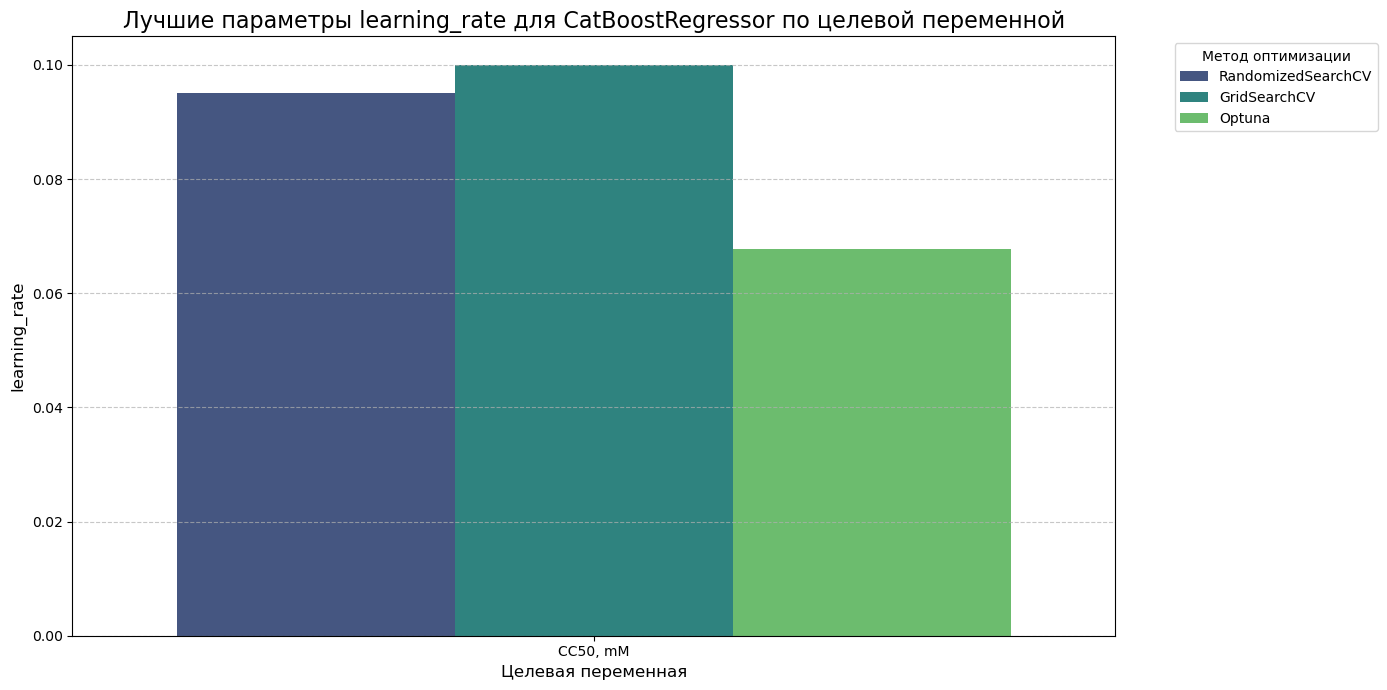

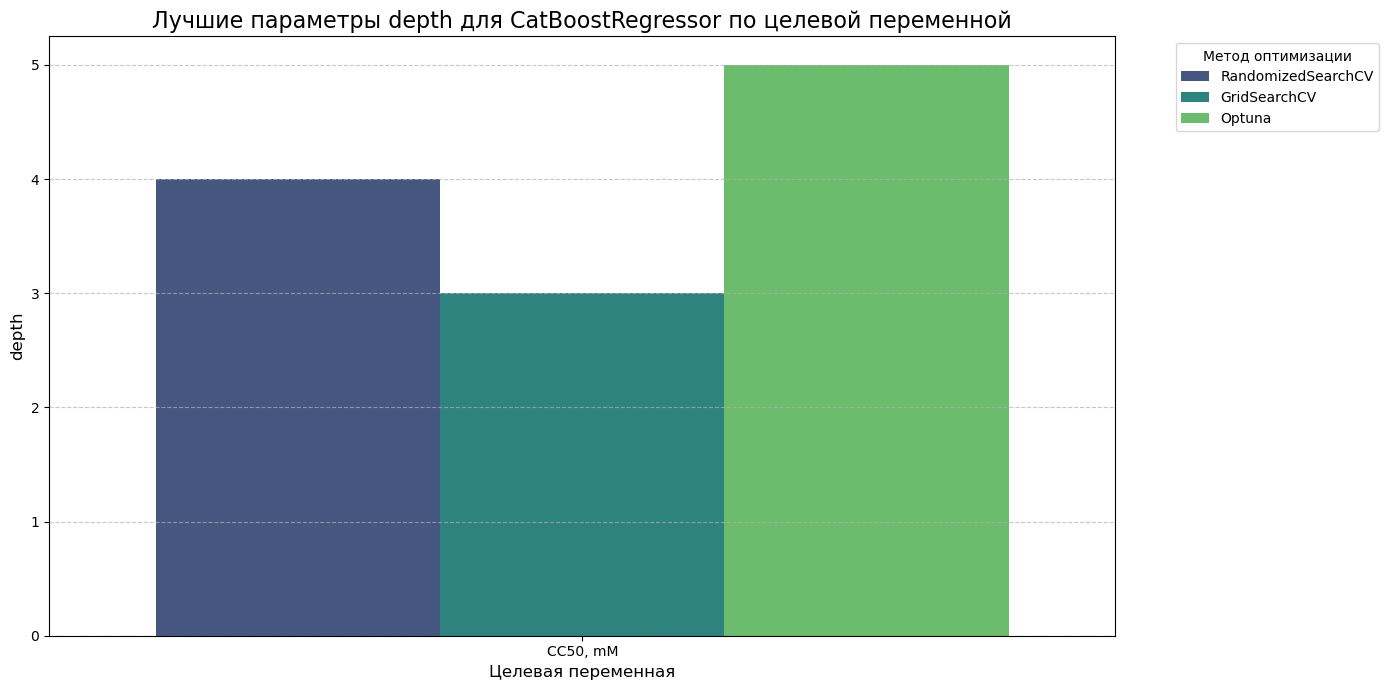

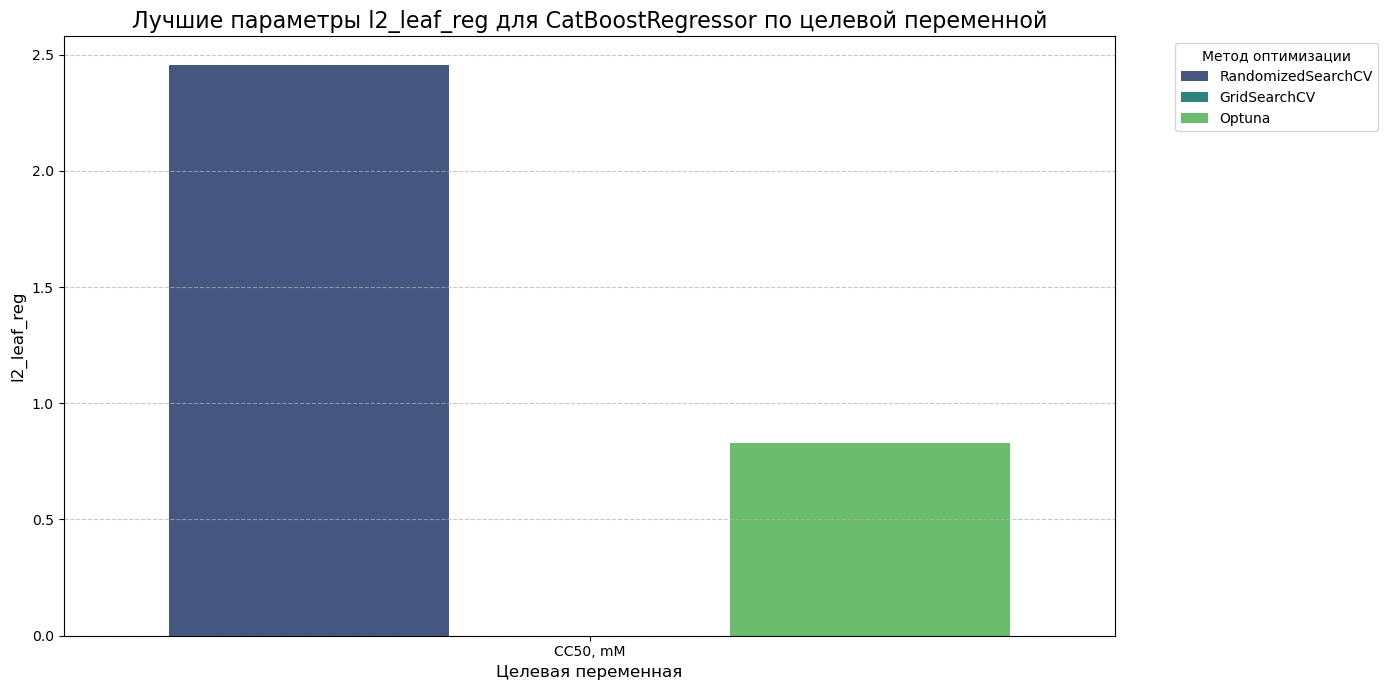


Графики параметров для XGBRegressor:


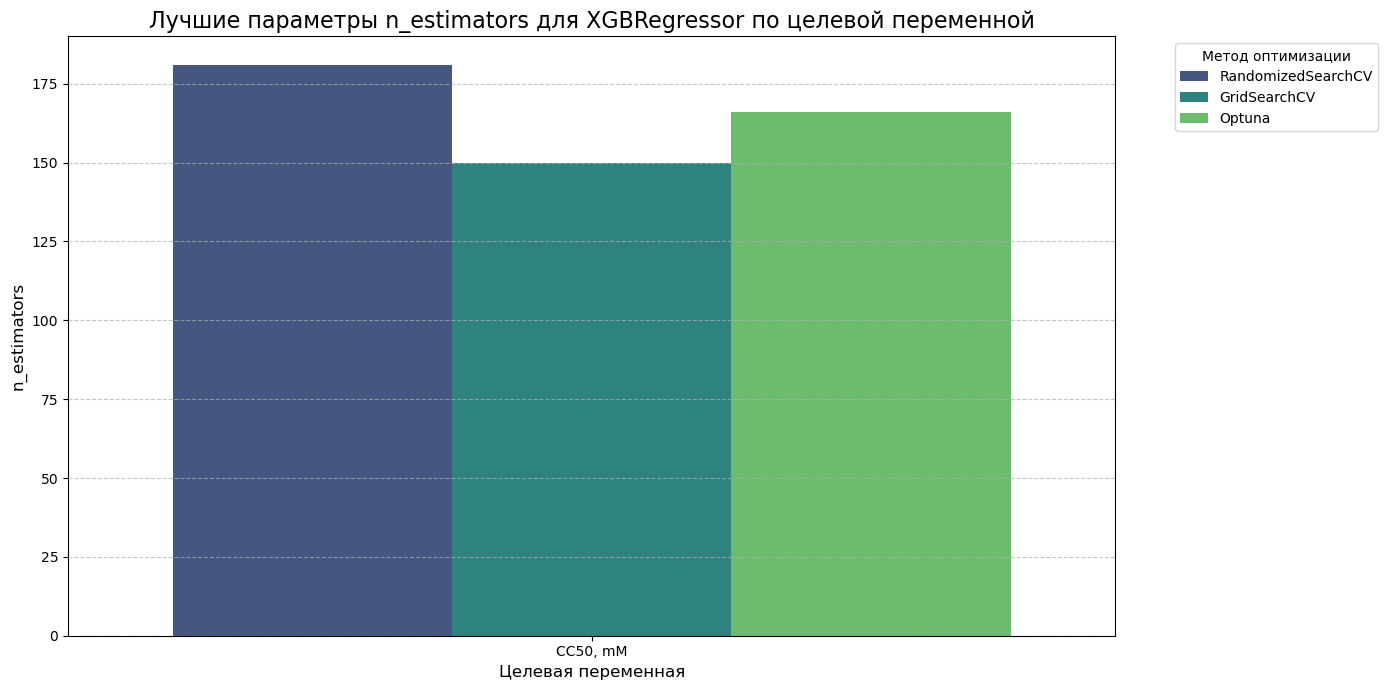

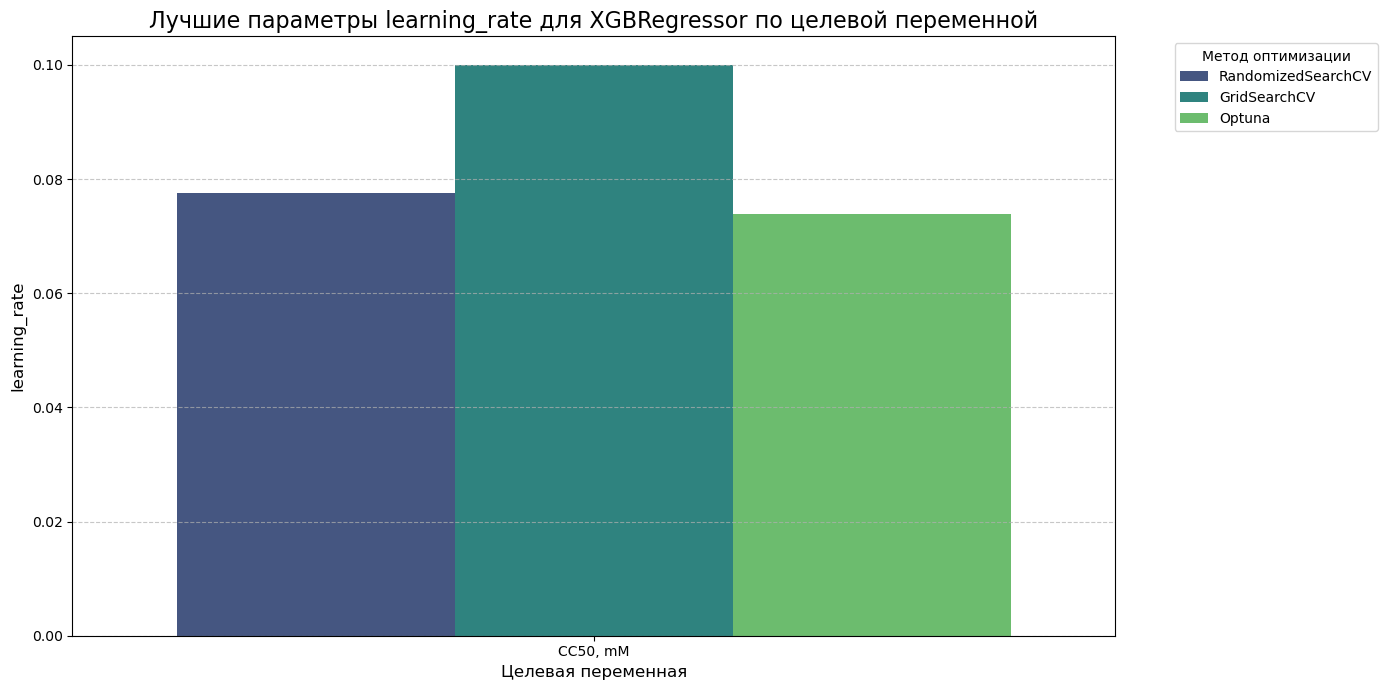

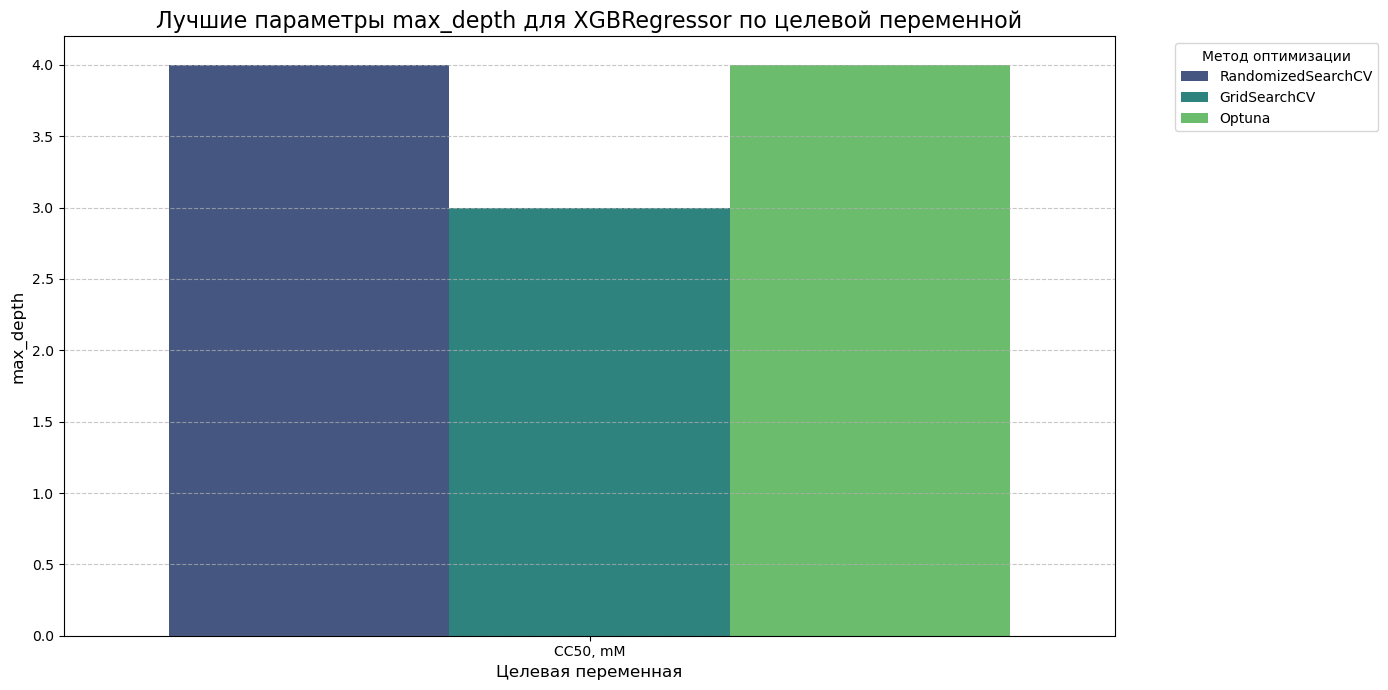

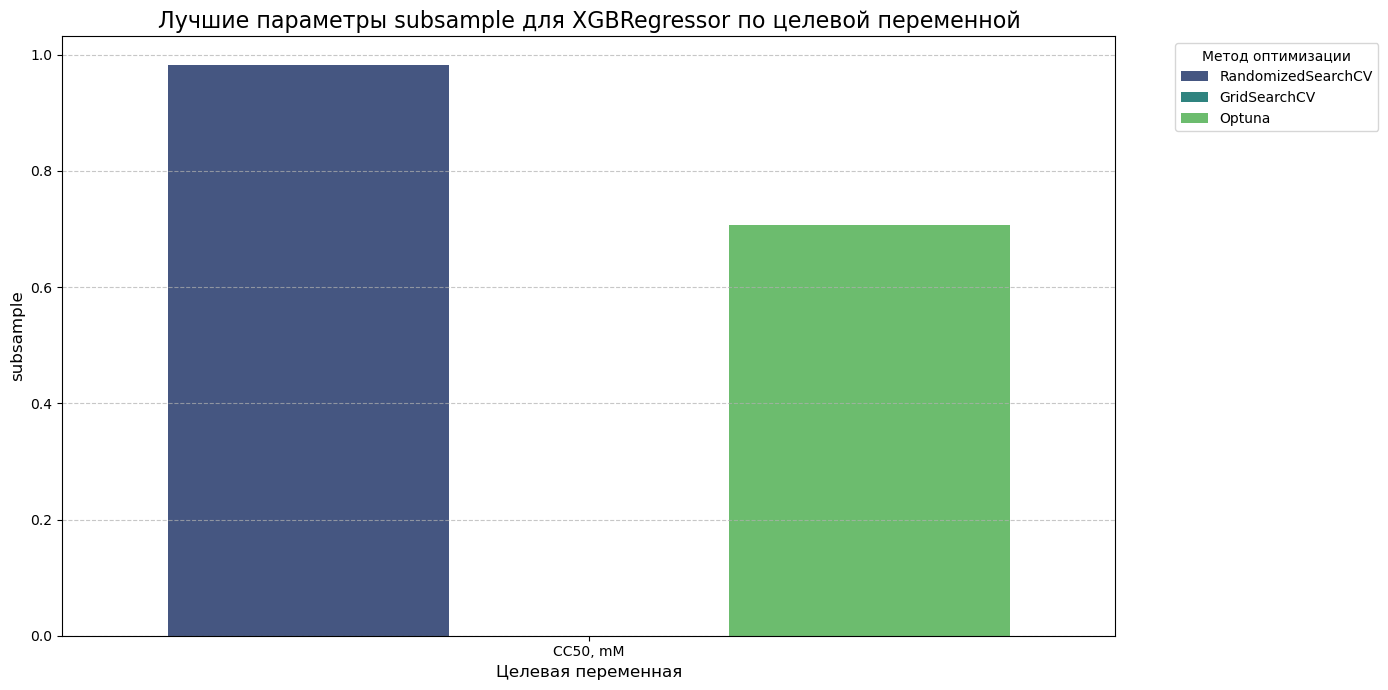


Графики параметров для RandomForestRegressor:


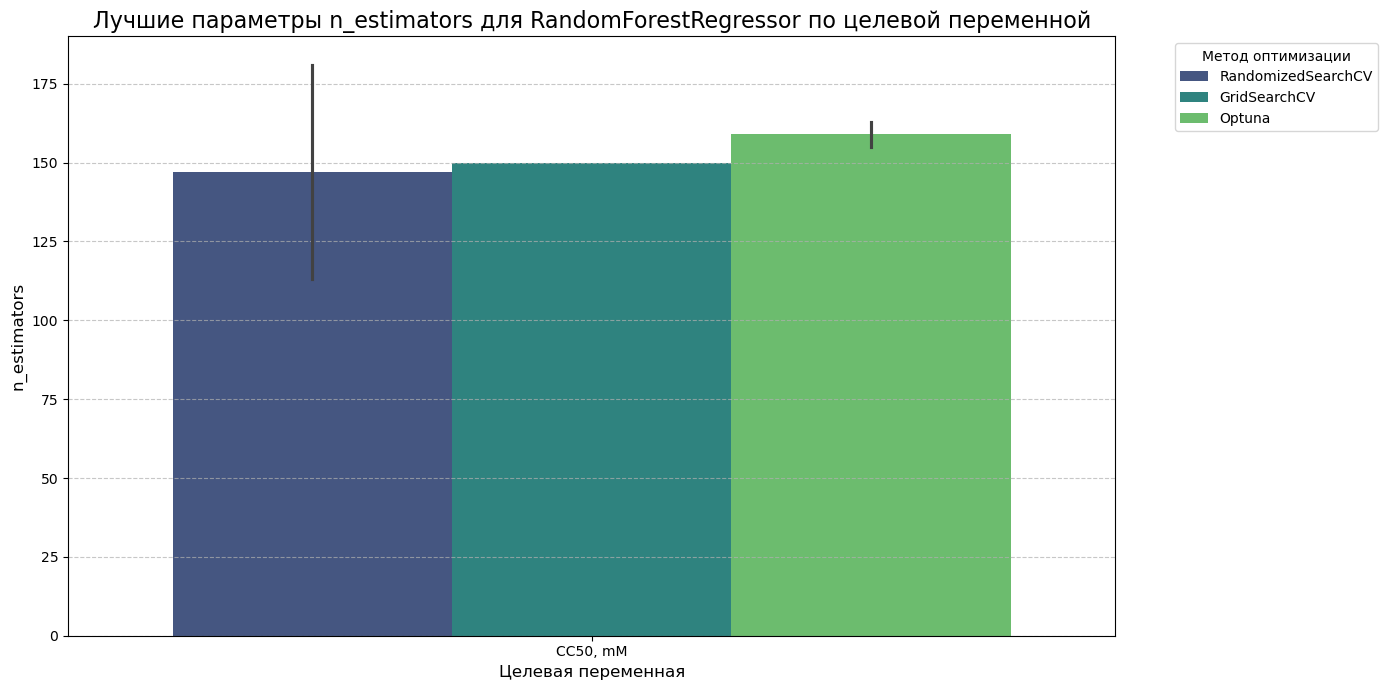

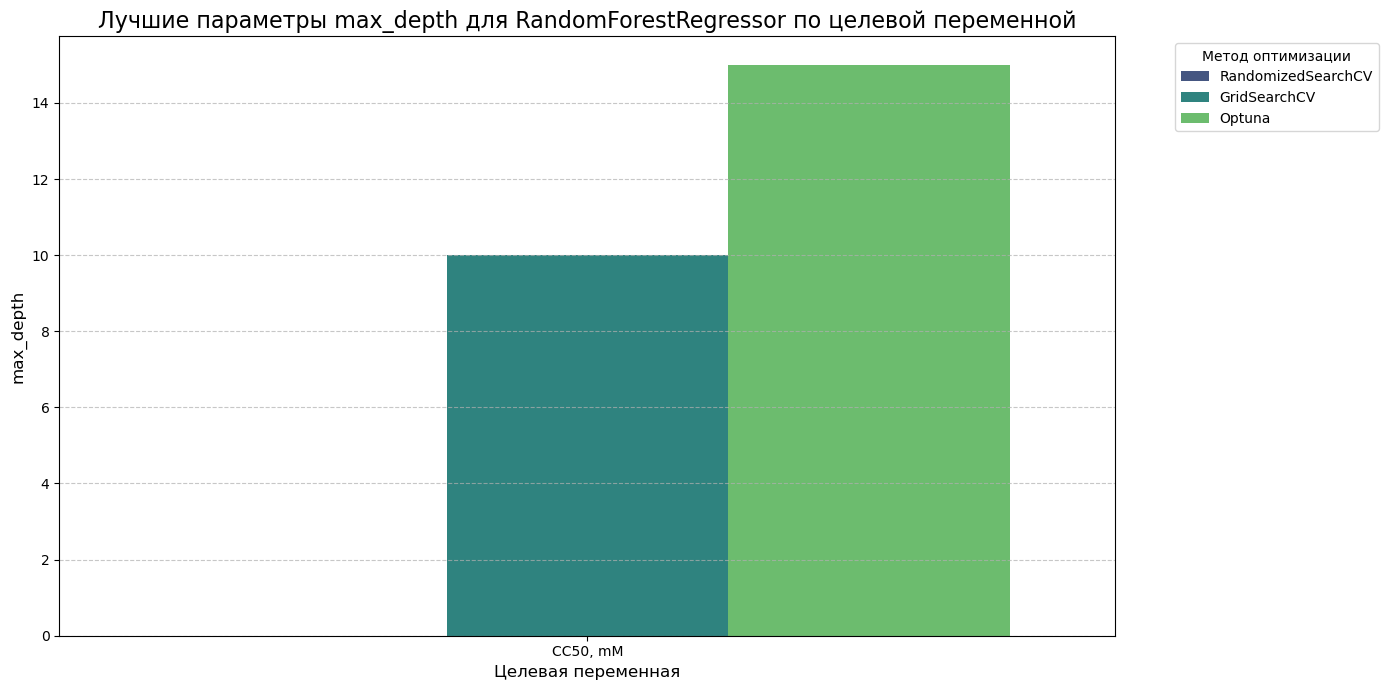

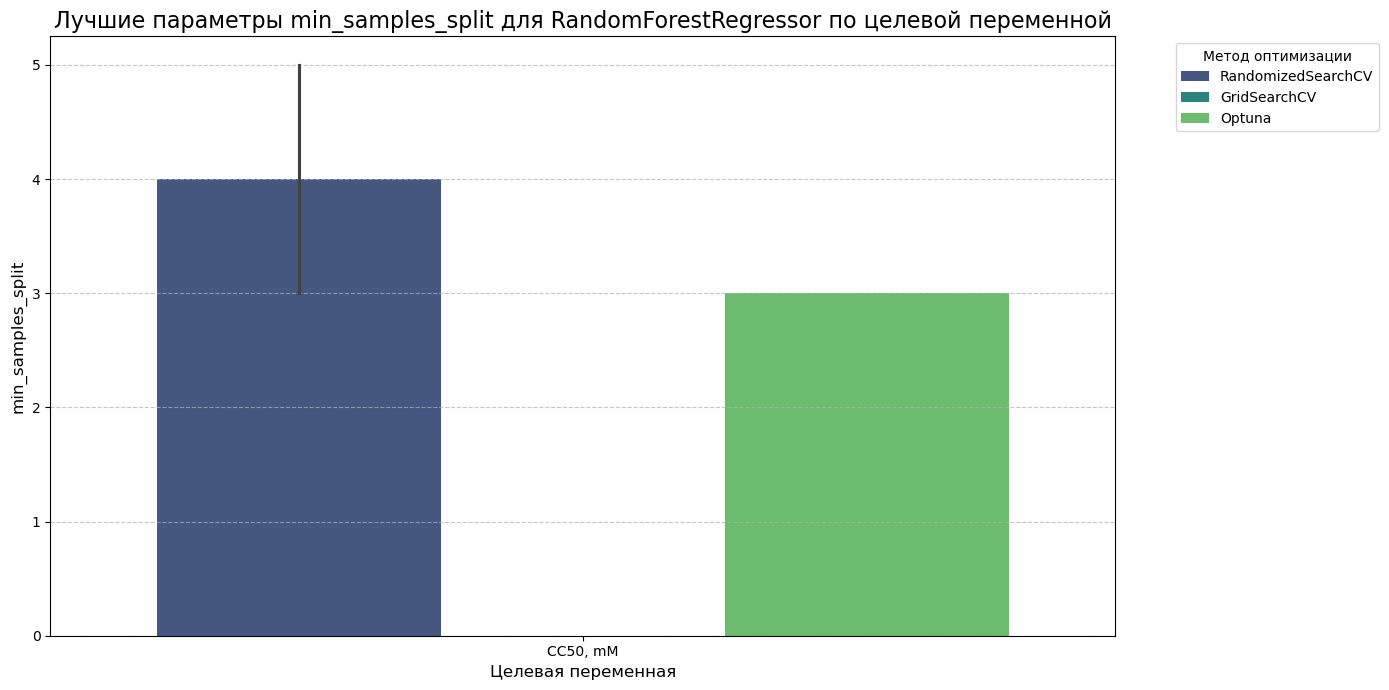


Графики параметров для MLPRegressor:


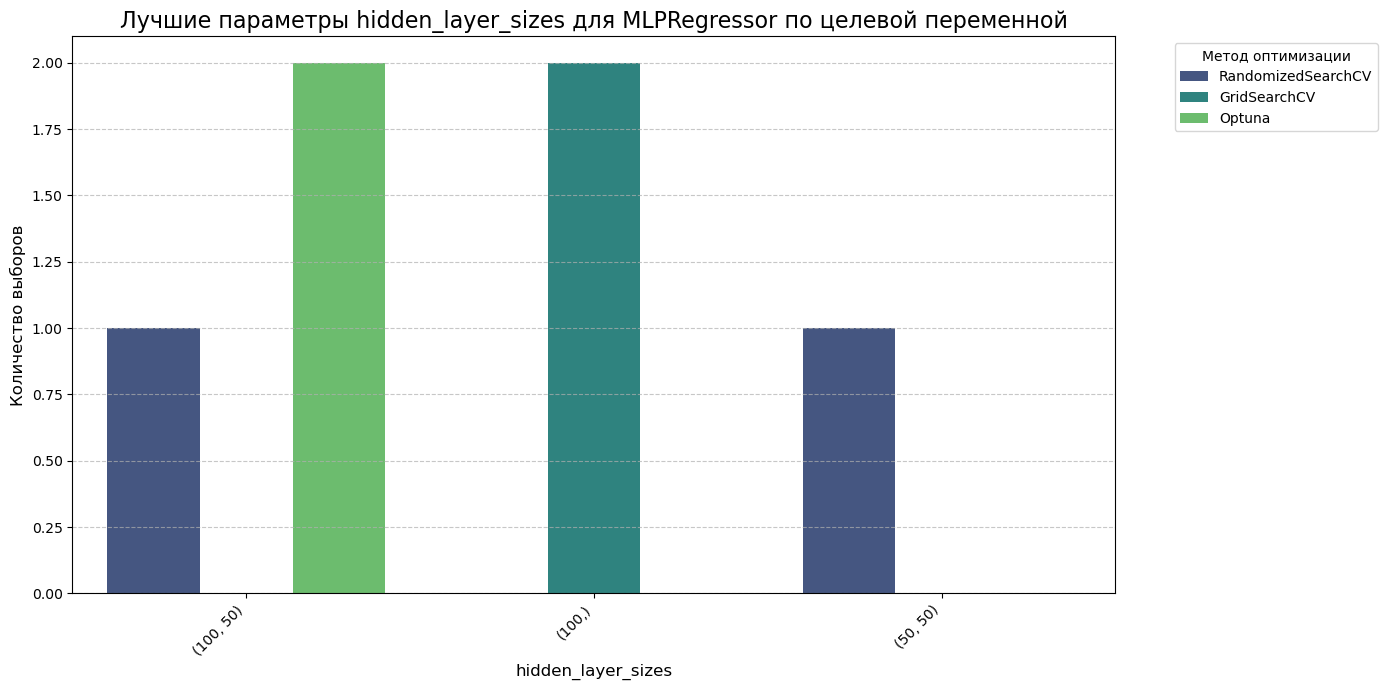

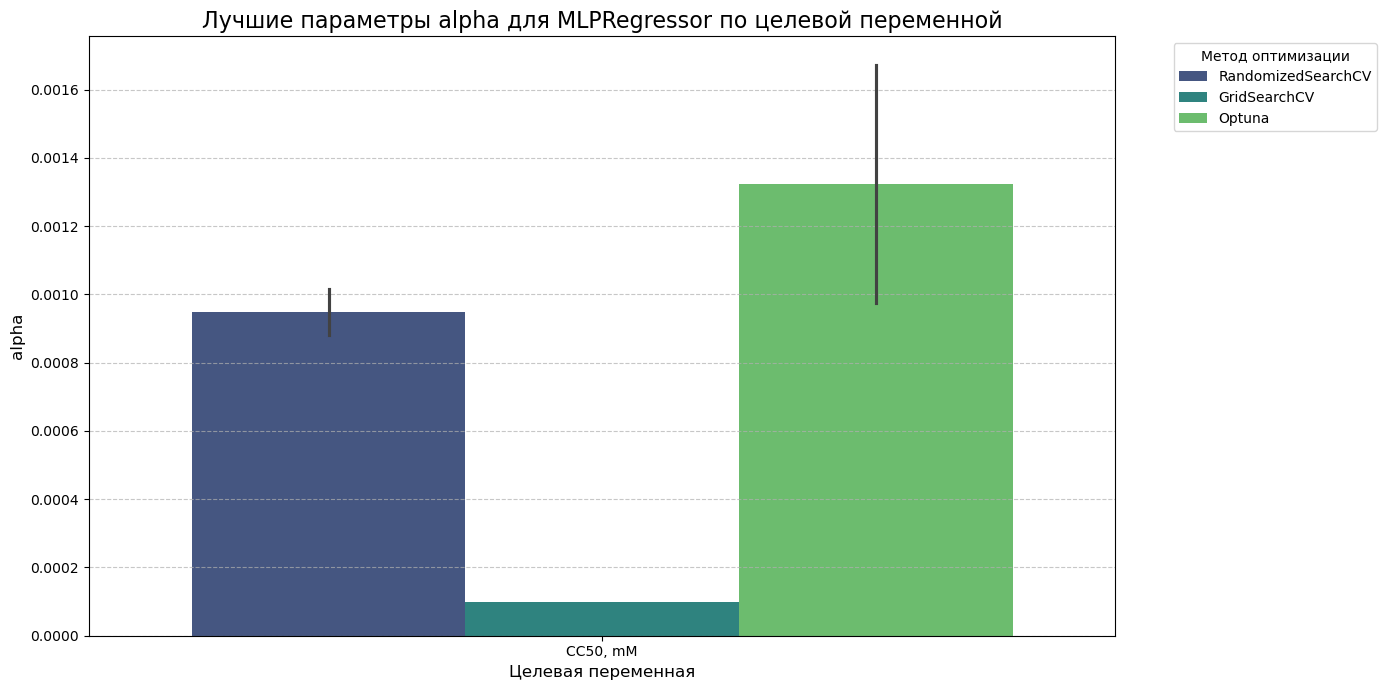

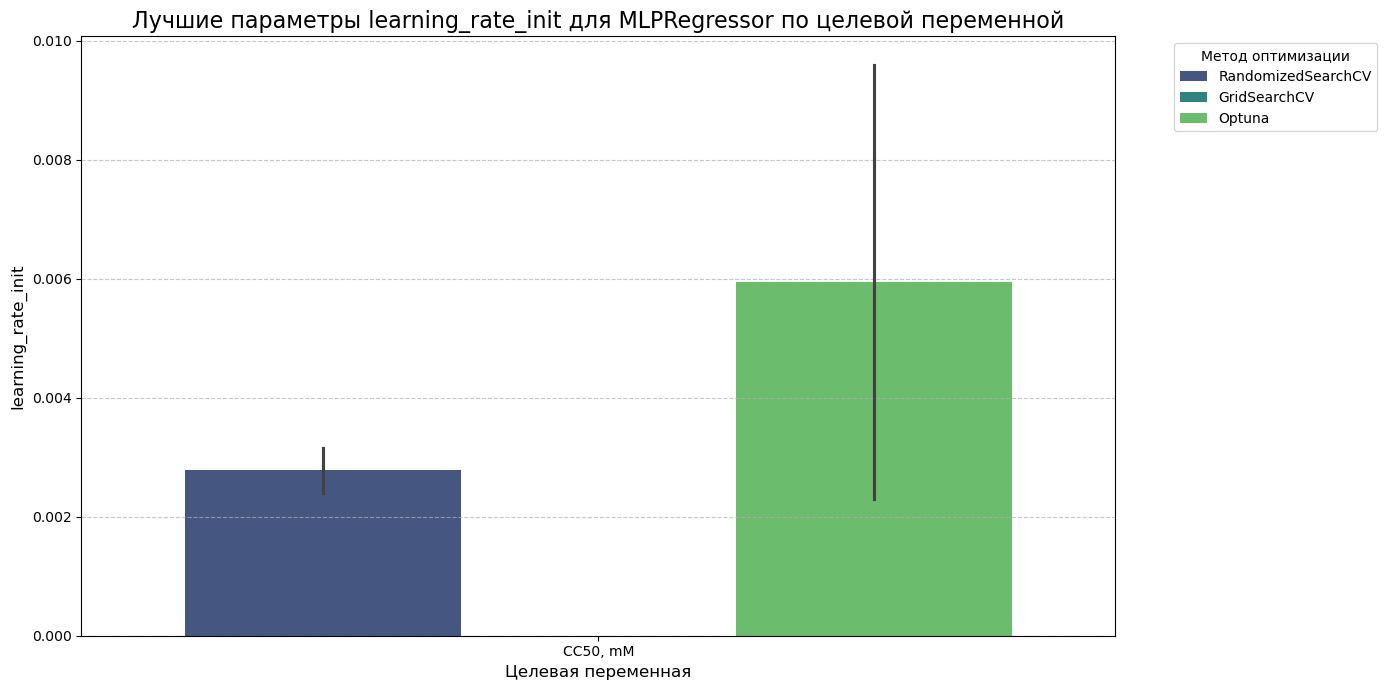


Построение графиков параметров завершено.


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
import ast # Импортируем ast для literal_eval


output_file = Path('model_results_all_optimizers_50_iter.csv')
all_results_df = pd.read_csv(output_file)

# Целевые переменные
TARGETS = ['CC50,_mM']

print("Строим графики по лучшим параметрам моделей...")

# --- Функция для извлечения параметров и построения графиков ---
def plot_best_params(df_results, model_name, param_names, title_prefix="Лучшие параметры"):
    """
    Строит графики лучших параметров для заданной модели.

    Args:
        df_results (pd.DataFrame): DataFrame с результатами моделей.
        model_name (str): Имя модели для фильтрации.
        param_names (list): Список имен параметров для отображения.
        title_prefix (str): Префикс для заголовка графика.
    """
    model_df = df_results[df_results['model'] == model_name].copy()

    if model_df.empty:
        print(f"Нет данных для модели: {model_name}. Пропуск графиков параметров.")
        return

    # Используем функцию для безопасного преобразования строки в словарь
    def safe_literal_eval(x):
        if pd.isna(x): # Проверяем на NaN
            return {}
        if isinstance(x, dict): # Если это уже словарь (возможно, после повторного запуска или сохранения)
            return x
        try:
            # ast.literal_eval может вызывать ошибку для пустых строк или некорректных форматов
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            # Если не удалось распарсить, возвращаем пустой словарь
            return {}

    model_df['parsed_params'] = model_df['best_params'].apply(safe_literal_eval)

    # Создаем отдельные столбцы для каждого параметра
    for param_name in param_names:
        # Получаем значение параметра, если оно есть, иначе NaN
        model_df[param_name] = model_df['parsed_params'].apply(lambda x: x.get(param_name, np.nan))

    # Удаляем строки, где все нужные параметры NaN (например, для LinearRegression, если мы случайно ее включили)
    # Примечание: Убедитесь, что список param_names действительно содержит параметры, которые могут отсутствовать
    # для некоторых строк (например, если оптимизатор не нашел параметры или модель их не имеет)
    model_df.dropna(subset=[p for p in param_names if p in model_df.columns], how='all', inplace=True)

    if model_df.empty:
        print(f"Нет действительных параметров для построения графиков для модели: {model_name}. Пропуск.")
        return

    print(f"\nГрафики параметров для {model_name}:")
    for param in param_names:
        # Дополнительная проверка, что столбец существует и не пуст
        if param in model_df.columns and not model_df[param].isnull().all():
            # Обработка 'hidden_layer_sizes' для MLPRegressor, чтобы barplot мог работать с числами
            if param == 'hidden_layer_sizes':
                # Преобразуем кортежи в строки для оси X, чтобы их можно было сравнивать как категории
                # И создаем уникальный числовой ID для каждого кортежа, чтобы ось Y была числовой для barplot
                # Или, что более наглядно, просто отображаем их как категории на оси X
                # Для barplot, если Y-ось числовая, а X-ось категориальная, то 'hidden_layer_sizes' должен быть на X
                temp_df = model_df.dropna(subset=[param]).copy()
                temp_df[param + '_str'] = temp_df[param].astype(str) # Преобразуем в строку для оси X

                plt.figure(figsize=(14, 7))
                sns.countplot(data=temp_df, x=param + '_str', hue='optimizer', palette='viridis')
                plt.title(f'{title_prefix} {param} для {model_name} по целевой переменной', fontsize=16)
                plt.ylabel('Количество выборов', fontsize=12) # Это счетчик для countplot
                plt.xlabel(param, fontsize=12)
                plt.xticks(rotation=45, ha='right', fontsize=10)
                plt.yticks(fontsize=10)
                plt.legend(title='Метод оптимизации', bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()

            else: # Для числовых параметров используем barplot
                plt.figure(figsize=(14, 7))
                sns.barplot(data=model_df, x='target', y=param, hue='optimizer', palette='viridis')
                plt.title(f'{title_prefix} {param} для {model_name} по целевой переменной', fontsize=16)
                plt.ylabel(param, fontsize=12)
                plt.xlabel('Целевая переменная', fontsize=12)
                plt.xticks(rotation=0, ha='center', fontsize=10)
                plt.yticks(fontsize=10)
                plt.legend(title='Метод оптимизации', bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
        else:
            print(f"Параметр '{param}' не найден или все значения NaN для модели {model_name}.")

# --- Вызовы функции для конкретных моделей и их параметров ---

# CatBoostRegressor
plot_best_params(all_results_df, "CatBoostRegressor", ['iterations', 'learning_rate', 'depth', 'l2_leaf_reg'])

# XGBRegressor
plot_best_params(all_results_df, "XGBRegressor", ['n_estimators', 'learning_rate', 'max_depth', 'subsample'])

# RandomForestRegressor
plot_best_params(all_results_df, "RandomForestRegressor", ['n_estimators', 'max_depth', 'min_samples_split'])

# MLPRegressor
# Для MLPRegressor 'hidden_layer_sizes' лучше всего визуализировать с помощью countplot,
# а остальные параметры - barplot
plot_best_params(all_results_df, "MLPRegressor", ['hidden_layer_sizes', 'alpha', 'learning_rate_init'])

print("\nПостроение графиков параметров завершено.")

In [29]:
import pandas as pd
from pathlib import Path
import ast # Нужен для безопасного преобразования строк в словари

# Предполагается, что all_results_df уже загружен или создан
output_file = Path('model_results_all_optimizers_50_iter.csv')
all_results_df = pd.read_csv(output_file)

# Функция для безопасного преобразования строки в словарь, которую мы уже использовали
def safe_literal_eval(x):
    if pd.isna(x):
        return {}
    if isinstance(x, dict):
        return x
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return {}

# Применяем функцию к столбцу 'best_params'
all_results_df['parsed_best_params'] = all_results_df['best_params'].apply(safe_literal_eval)

# Выбираем столбцы для сводной таблицы
# Включаем ключевые метрики и разобранные параметры
summary_columns = ['model', 'optimizer', 'target', 'rmse', 'r2', 'parsed_best_params']
summary_df = all_results_df[summary_columns].copy()

# Переименовываем 'parsed_best_params' в 'Best Parameters' для лучшей читаемости
summary_df.rename(columns={'parsed_best_params': 'Best Parameters'}, inplace=True)

# Сортируем для лучшей читаемости: сначала по целевой переменной, затем по модели, затем по оптимизатору
summary_df_sorted = summary_df.sort_values(by=['target', 'model', 'optimizer']).reset_index(drop=True)

print("--- Сводная таблица лучших параметров ---")
print(summary_df_sorted.to_string()) # Используем to_string(), чтобы избежать усечения вывода
print("\n--- Конец сводной таблицы ---")

--- Сводная таблица лучших параметров ---
                    model           optimizer    target      rmse        r2                                                                                                Best Parameters
0       CatBoostRegressor        GridSearchCV  CC50, mM  0.269931  0.967963                                                          {'depth': 3, 'iterations': 150, 'learning_rate': 0.1}
1       CatBoostRegressor        GridSearchCV  CC50, mM  0.258491  0.970621                                                          {'depth': 3, 'iterations': 150, 'learning_rate': 0.1}
2       CatBoostRegressor              Optuna  CC50, mM  0.239675  0.974742       {'iterations': 192, 'learning_rate': 0.06768269073143275, 'depth': 5, 'l2_leaf_reg': 0.8306050731972228}
3       CatBoostRegressor              Optuna  CC50, mM  0.232070  0.976320       {'iterations': 192, 'learning_rate': 0.06768269073143275, 'depth': 5, 'l2_leaf_reg': 0.8306050731972228}
4       CatBoostRegress